In [1]:
import graph_tool.all as gt
import sys, os
import graph_embeddings
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

2022-07-27 16:29:55.333311: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-27 16:29:55.333486: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-27 16:29:55.334379: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
G = nx.read_gml("notebooks/2022_07_17_graph_reconstruction/data/polbooks.gml")
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)

In [3]:
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G).asfptype()

In [4]:
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

In [5]:
models = {}
window_length = 5
num_walks = 10
dim = 128
# deep walk is word2vec with cbow + hierarchical softmax, baseline
# shouldnt this be called biased?
# compare these three models to each other, using some metric
models["Unbiased"] = model = graph_embeddings.DeepWalk(
    window_length=window_length, restart_prob=0, num_walks=num_walks
)

models["degree-unbiased"] = rv.residual2vec_sgd(
    # sbm based node sampling
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

In [6]:

def dcSBM(A, group_membership):
    # Initalize the parameters
    n_nodes = A.shape[0]

    # Initialize the group membership
    if group_membership is None:
        group_membership = np.zeros(n_nodes, dtype=np.int64)
        node2group = rv.utils.to_member_matrix(group_membership)
    else:
        node2group = rv.utils.to_member_matrix(group_membership)

    indeg = np.array(A.sum(axis=0)).reshape(-1)
    probs = (node2group.T @ A @ node2group).toarray()
    gt_params = {
        "b": group_membership,
        "probs": probs,
        "micro_degs": True,
        "in_degs": indeg,
        "out_degs": indeg,
    }
    g = gt.generate_sbm(**gt_params)
    Ar = gt.adjacency(g).T
    Ar.data = np.ones_like(Ar.data)
    return Ar

In [7]:
# %%


class RandomEmbeddingSampler(rv.NodeSampler):
    """Node Sampler based on an embedding"""

    def __init__(self, model, randomizer, dim, k=10):
        """Node Sampler based on an embedding.
        Given a center node, a context node will be sampled with
        probability given by
        """

        # Reindex the group membership
        self.model = model
        self.dim = dim
        self.randomizer = randomizer
        self.k = k

    def fit(self, A):
        Ar = self.randomizer(A)
        self.model.fit(Ar)
        self.model.transform(self.dim)
        self.in_vec = self.model.in_vec.astype("float32")
        self.out_vec = self.model.out_vec.astype("float32")
        self.index = faiss.IndexFlatIP(self.dim)
        self.index.add(self.out_vec)
        self.k = np.minimum(A.shape[0], self.k)

        return self

    def sampling(self, center_nodes, context_nodes, padding_id):
        sim, indices = self.index.search(self.in_vec[center_nodes, :], k=int(self.k))
        sim = np.exp(sim)
        sim = np.einsum("ij,i->ij", sim, 1 / np.array(np.sum(sim, axis=1)).reshape(-1))
        sim = np.cumsum(sim, axis=1)
        retval = np.zeros(sim.shape[0], dtype=np.int64)
        for j in range(sim.shape[0]):
            retval[j] = int(indices[j, np.searchsorted(sim[j, :], np.random.rand())])
        return retval

In [8]:
base_model = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)
noise_sampler = RandomEmbeddingSampler(
    base_model, randomizer=lambda x: dcSBM(x, group_ids), dim=dim
)

In [9]:
models["group-unbiased"] = rv.residual2vec_sgd(
    # noise_sampler=noise_sampler,
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

In [10]:
models

{'Unbiased': <graph_embeddings.embeddings.DeepWalk at 0x7f3c5845b090>,
 'degree-unbiased': <residual2vec.residual2vec_sgd.residual2vec_sgd at 0x7f3c584d4f10>,
 'group-unbiased': <residual2vec.residual2vec_sgd.residual2vec_sgd at 0x7f3c584cf510>}

In [11]:
embs = {}
for k, model in models.items():
    print(model.__class__.__name__)
    emb = model.fit(A).transform(dim=dim)
    embs[k] = emb

DeepWalk
residual2vec_sgd


100%|██████████| 329/329 [00:00<00:00, 332.31it/s, loss=1.31] 


residual2vec_sgd


100%|██████████| 329/329 [00:00<00:00, 453.93it/s, loss=1.22]


In [12]:
for i in embs.keys():
    print(i)
    print(embs[i].shape, )

Unbiased
(105, 128)
degree-unbiased
(105, 128)
group-unbiased
(105, 128)


In [13]:
def reconstruct_graph(emb, n, m):
    #    k = int(np.ceil(m / n))
    #    A = kneighbors_graph(emb, k, mode="distance", include_self=False, metric="cosine")
    #    A.data = 1 - A.data
    #    return nx.from_scipy_sparse_matrix(A)
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)

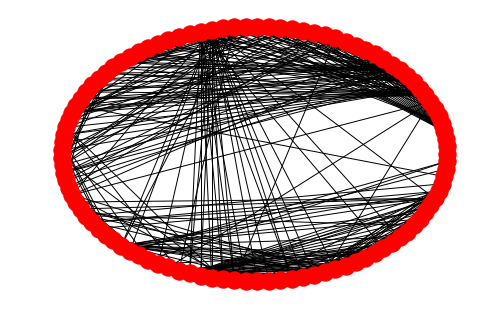

In [14]:
nx.draw(nx.from_scipy_sparse_matrix(A), with_labels=False, pos=nx.circular_layout(nx.from_scipy_sparse_matrix(A)))

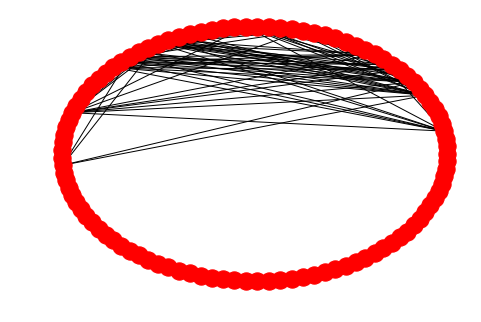

In [15]:
nx.draw(reconstruct_graph(embs["Unbiased"], A.shape[0], A.shape[0]), with_labels=False, pos=nx.circular_layout(reconstruct_graph(embs["Unbiased"], A.shape[0], A.shape[0])))

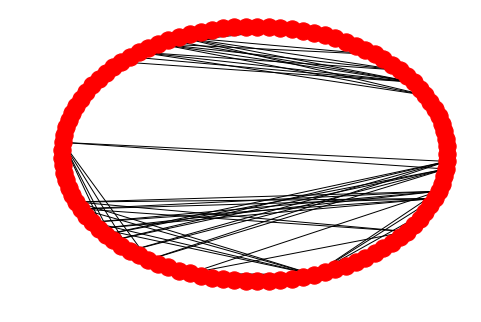

In [16]:
nx.draw(reconstruct_graph(embs["degree-unbiased"], A.shape[0], A.shape[0]), with_labels=False, pos=nx.circular_layout(reconstruct_graph(embs["degree-unbiased"], A.shape[0], A.shape[0])))

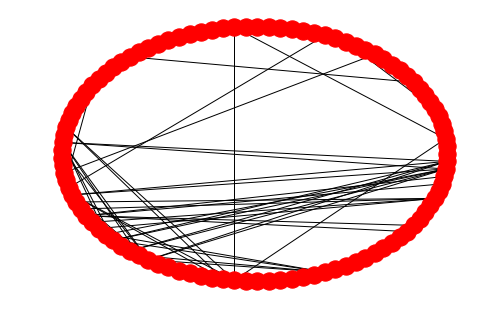

In [17]:
nx.draw(reconstruct_graph(embs["group-unbiased"], A.shape[0], A.shape[0]), with_labels=False, pos=nx.circular_layout(reconstruct_graph(embs["group-unbiased"], A.shape[0], A.shape[0])))

In [18]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [19]:
X = embs["Unbiased"].copy()
X = np.hstack([X, deg.reshape((-1, 1))])
clf = LinearDiscriminantAnalysis(n_components=2, shrinkage=0.01, solver="eigen")
# xys = clf.fit_transform(X, group_ids)
xys = PCA(n_components=2).fit_transform(X)
# xys[:, 1] = deg/np.sum(deg)
pos = {i: xys[i, :] for i in range(xys.shape[0])}

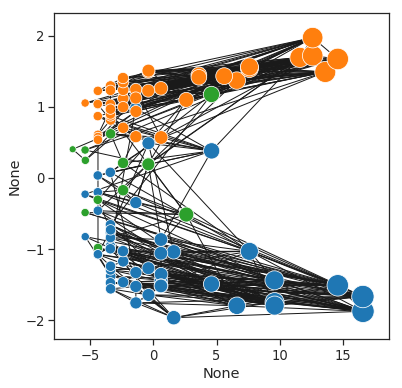

In [20]:
# %%
# Plot the original graph
#
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(6, 6))

nx.draw_networkx_edges(G, pos, ax=ax)
sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    hue=group_ids,
    size=deg,
    sizes=(50, 500),
    palette="tab10",
    ax=ax,
)
# ax.axis("off")
ax.legend().remove()

fig.savefig("original_graph.pdf", bbox_inches="tight", dpi=300)


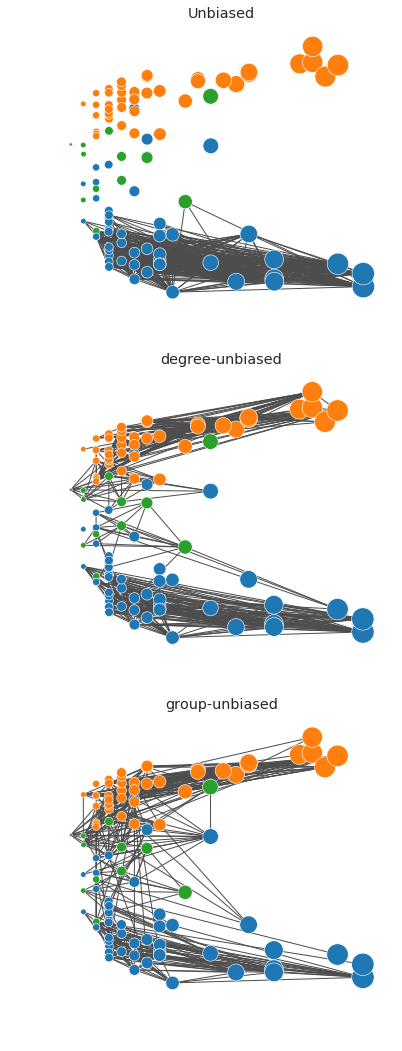

In [21]:

# %% Plot the reconstructed graphs
fig, axes = plt.subplots(figsize=(6, 6 * len(rgraphs)), nrows=len(rgraphs), ncols=1)

for i, (k, v) in enumerate(rgraphs.items()):
    ax = axes[i]
    weights = [rgraphs[k][u][v]["weight"] for u, v in rgraphs[k].edges()]
    nx.draw_networkx_edges(rgraphs[k], pos, ax=ax, edge_color="#4d4d4d")
    sns.scatterplot(
        x=xys[:, 0],
        y=xys[:, 1],
        hue=group_ids,
        size=deg,
        sizes=(10, 500),
        palette="tab10",
        ax=ax,
    )
    ax.axis("off")
    ax.legend().remove()
    ax.set_title(k)

fig.savefig("reconstructed_graph.pdf", bbox_inches="tight", dpi=300)

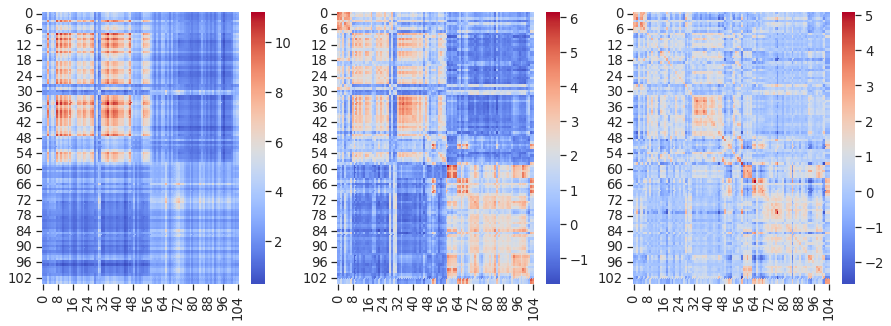

In [22]:
# %%
# %%
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(15, 5), ncols=3)

for i, (k, v) in enumerate(embs.items()):
    X = embs[k]
    ax = sns.heatmap(X @ X.T, ax=axes[i], cmap = "coolwarm")